In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip "/content/drive/My Drive/Content-Summary_CleanData.zip" -d "/content/extracted_files"

Archive:  /content/drive/My Drive/Content-Summary_CleanData.zip
  inflating: /content/extracted_files/Content-Summary_CleanData.csv  


In [4]:
import pandas as pd

df = pd.read_csv('/content/extracted_files/Content-Summary_CleanData.csv')
df.head()

,Content,Summary
0,New York police are concerned drones could bec...,Police have investigated criminals who have ri...
1,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...
2,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...
3,An Ebola outbreak that began in Guinea four mo...,World Health Organisation: 635 infections and ...
4,By . Associated Press and Daily Mail Reporter ...,A sinkhole opened up at 5:15am this morning in...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580164 entries, 0 to 580163
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  580164 non-null  object
 1   Summary  580164 non-null  object
dtypes: object(2)
memory usage: 8.9+ MB


In [ ]:
# pip install pandas transformers torch

In [ ]:
import pandas as pd
data = pd.read_csv('/content/extracted_files/Content-Summary_CleanData.csv')[:100]

In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertConfig
from torch.utils.data import TensorDataset,DataLoader

class UniLMTokenizer(BertTokenizer):
    def __init__(self, vocab_file, do_lower_case=True):
        super().__init__(vocab_file=vocab_file, do_lower_case=do_lower_case)

#UNILM model is an extension of BERT, Feel free to modify it as per original paper
class UniLMModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', config=config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        logits = self.lm_head(sequence_output)
        return logits

In [ ]:
!wget https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt

--2024-11-07 12:17:33--  https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt
Resolving huggingface.co (huggingface.co)... 18.239.50.16, 18.239.50.49, 18.239.50.103, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231508 (226K) [text/plain]
Saving to: ‘vocab.txt.1’

vocab.txt.1         100%[===================>] 226.08K  --.-KB/s    in 0.01s   

2024-11-07 12:17:33 (18.4 MB/s) - ‘vocab.txt.1’ saved [231508/231508]



In [ ]:
tokenizer = UniLMTokenizer(vocab_file='/content/vocab.txt', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Tokenize the content and summary columns
tokenized_inputs = data['Content'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
tokenized_summaries = data['Summary'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [ ]:
# define the maximum sequence length
max_seq_length = 512

# Truncate and pad the tokenized inputs and summaries
input_ids = []
summary_ids = []

for tokens in tokenized_inputs:
    if len(tokens) > max_seq_length:
        tokens = tokens[:max_seq_length]
    else:
        tokens = tokens + [0] * (max_seq_length - len(tokens))
    input_ids.append(tokens)

for tokens in tokenized_summaries:
    if len(tokens) > max_seq_length:
        tokens = tokens[:max_seq_length]
    else:
        tokens = tokens + [0] * (max_seq_length - len(tokens))
    summary_ids.append(tokens)

# Convert the tokenized inputs and summaries to tensors
input_ids = torch.tensor(input_ids, dtype=torch.long)
summary_ids = torch.tensor(summary_ids, dtype=torch.long)

In [ ]:
# creating dataset and dataloaders

In [ ]:
# Create TensorDataset
dataset = TensorDataset(input_ids, summary_ids)

# Define batch size
batch_size = 1

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Defining the config for UniLM

config = BertConfig(
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=512,
    vocab_size=tokenizer.vocab_size
)

In [ ]:
# Initialising the UniLM model with desired config, loss function and optimizer

model = UniLMModel(config)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for step,batch in enumerate(dataloader):
        input_batch, summary_batch = batch
        input_batch = input_batch.to(device)
        summary_batch = summary_batch.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_batch, attention_mask=input_batch.ne(0))[0]

        # Compute loss
        loss = loss_fn(outputs.view(-1, outputs.shape[-1]), summary_batch.view(-1))
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        if step%100==0:
            print("Step-{}, Loss-{}".format(step,loss.item()))

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(dataloader)

    # Print the average loss
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")


Step-0, Loss-10.55798625946045
Epoch 1/50 - Average Loss: 4.6225
Step-0, Loss-1.8975038528442383
Epoch 2/50 - Average Loss: 2.1864
Step-0, Loss-4.919294834136963
Epoch 3/50 - Average Loss: 1.9462
Step-0, Loss-1.2646875381469727
Epoch 4/50 - Average Loss: 1.7503
Step-0, Loss-0.8954195976257324
Epoch 5/50 - Average Loss: 1.6234
Step-0, Loss-1.243207573890686
Epoch 6/50 - Average Loss: 1.5388
Step-0, Loss-1.2369871139526367
Epoch 7/50 - Average Loss: 1.4640
Step-0, Loss-3.9686381816864014
Epoch 8/50 - Average Loss: 1.3924
Step-0, Loss-4.783018112182617
Epoch 9/50 - Average Loss: 1.3303
Step-0, Loss-0.38486984372138977
Epoch 10/50 - Average Loss: 1.2676
Step-0, Loss-0.4802406132221222
Epoch 11/50 - Average Loss: 1.2300
Step-0, Loss-1.3762600421905518
Epoch 12/50 - Average Loss: 1.1830
Step-0, Loss-0.625546395778656
Epoch 13/50 - Average Loss: 1.1446
Step-0, Loss-0.5427001118659973
Epoch 14/50 - Average Loss: 1.1248
Step-0, Loss-0.38393375277519226
Epoch 15/50 - Average Loss: 1.1102
Step-0,

In [ ]:
input_text = "The camaraderie between the two leaders was on display on Wednesday as PM Modi became one of the first leaders to congratulate my friend Trump on his historic win in the presidential polls. The post was accompanied by photos of the two leaders holding hands at rallies in Gujarat and Texas during Trump's first term.The post was quickly followed by a phone call, in which Trump told PM Modi that he considers him and India a true friend. Trump also said that the whole world loves PM Modi, and he was a magnificent man. Weeks ago, Trump called PM Modi a total killer."

In [ ]:
# Tokenizing the input text

tokenized_input = tokenizer.encode_plus(input_text, max_length=max_seq_length, truncation=True, padding='max_length', return_tensors='pt')

In [ ]:
# Moving the tokenized input to the device (cude)
input_ids = tokenized_input['input_ids'].to(device)
attention_mask = tokenized_input['attention_mask'].to(device)

In [ ]:
# Setting the model to evaluation mode

model.eval()

UniLMModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
# Performing forward pass

with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)


In [ ]:
# Reshaping the output tensor and generating summary. You can use longer sentences to generate better summary, We took a random text.

In [ ]:
# Reshape the outputs tensor
reshaped_outputs = outputs.permute(0, 2, 1)  # Reshape to (batch_size, vocab_size, sequence_length)

# Get the predicted summary
predicted_summary_ids = torch.argmax(reshaped_outputs, dim=1)
predicted_summary = tokenizer.decode(predicted_summary_ids[0], skip_special_tokens=True)

print("Predicted Summary:", predicted_summary)

Predicted Summary: ......


# DATE - 25/11/24

In [5]:
from transformers import pipeline
from nltk import sent_tokenize     # sentence tokenizer

import nltk

import torch  # pip install torch torchvision torchaudio

from glob import glob

import pandas as pd

import numpy as np

In [6]:
df2 = df

In [7]:
df2.iloc[0,0]

"New York police are concerned drones could become tools for terrorists, and are investigating ways to stop potential attacks. Until now police haven't acknowledged drones as a potential weapon, but the NYPD has now said the technology has advanced enough that someone could use them to carry out an air assault using chemical weapons and firearms. Police want to develop technology which will allow them to take control of drones as well as scan the skies for them before major events. The NYPD says drones carrying explosives are the number one threat as they investigate ways to stop attacks . Deputy Chief Salvatore DiPace, left, was concerned about an incident last year where a drone was landed in front of German Chancellor Angela Merkel and 'could have took the chancellor and her people out' A drone which was flown over a packed football stadium in Manchester, England, just over a week ago, resulting in the suspected pilot being arrested . They are consulting with the military and member

In [8]:
# lets Check the number of tokens we have here

from transformers import BartTokenizer

# Initialize the tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-mnli")

# Your input text
input_text = """New York police are concerned drones could become tools for terrorists, and are investigating ways to stop potential attacks. Until now police haven't acknowledged drones as a potential weapon, but the NYPD has now said the technology has advanced enough that someone could use them to carry out an air assault using chemical weapons and firearms. Police want to develop technology which will allow them to take control of drones as well as scan the skies for them before major events. The NYPD says drones carrying explosives are the number one threat as they investigate ways to stop attacks. Deputy Chief Salvatore DiPace, left, was concerned about an incident last year where a drone was landed in front of German Chancellor Angela Merkel and 'could have took the chancellor and her people out.' A drone which was flown over a packed football stadium in Manchester, England, just over a week ago, resulting in the suspected pilot being arrested. They are consulting with the military and members of its counterterrorism, bomb squad, emergency services and aviation units are working on a plan to counter weaponized drones. The NYPD hasn't received any intelligence indicating there is an imminent threat, but has become increasingly concerned over the last year. Deputy Chief Salvatore DiPace told CBS News: 'We've looked at some people that have jury-rigged these drones to carry guns, to carry different types of explosives if they wanted to; there's just so many possibilities that we're very worried about.' Mr Dipace said police had also seen video showing how accurate an attack from a drone could be: 'We've seen some video where the drone was flying at different targets along the route and very accurately hitting the targets with the paintball. The NYPD now sees a drone carrying explosives as the number one threat. Mr DiPace's concerns follow an incident in Germany last year where a drone was able to land just in front of German Chancellor Angela Merkel as she delivered a speech. The drone, circled, landed in front of Ms Merkel as she delivered a speech sin Germany sparking fears that the device could easily be used to commit a terrorist act. He said: 'If you really think about what could have happened there, the drone hit its target right on the mark and could have took the chancellor and her people out.' There has been a dramatic increase of incidents involving drones in New York City in the last year, with 40 recorded. In some cases unmanned aircraft systems or drones had flown into airspace being used by NYPD helicopters. In one incident this summer, a drone which was almost 800 feet off the ground, nearly collided with a police helicopter. NYPD Aviation Unit Member, Sergeant Antonio Hernandez said: 'We're flying in the dark; we have night-vision goggles on, we're trying to get a job done and then the next thing you know we see this drone come up to our altitude.'"""

# Tokenize the input
tokens = tokenizer.encode(input_text)

# Check the number of tokens
num_tokens = len(tokens)
print(f"Number of tokens: {num_tokens}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Number of tokens: 569


In [9]:
nltk.download('punkt')  # library used for used for sentence tokenization , divides a text into a list of sentences, using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
# LOAD model


model_name = "facebook/bart-large-mnli"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")


Using device: cuda:0


In [11]:
# function to load the model
def load_model(device):
  news_sentiment_analysis = pipeline(     # transformers pipeline
      "zero-shot-classification",   # give it the task
      model=model_name,               # giving it model that we want to use
      device=device)                # device it will use

  return news_sentiment_analysis


In [12]:
news_sentiment_analysis = load_model(device)

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [13]:
sentiment_list =  ["positive", "negative", "neutral", "joy", "sadness", "anger", "fear", "trust"]

In [14]:
analysis_output = news_sentiment_analysis(
    df2.iloc[0,0],
    candidate_labels=sentiment_list,
    multi_label=True,
)

In [15]:
analysis_output

{'sequence': "New York police are concerned drones could become tools for terrorists, and are investigating ways to stop potential attacks. Until now police haven't acknowledged drones as a potential weapon, but the NYPD has now said the technology has advanced enough that someone could use them to carry out an air assault using chemical weapons and firearms. Police want to develop technology which will allow them to take control of drones as well as scan the skies for them before major events. The NYPD says drones carrying explosives are the number one threat as they investigate ways to stop attacks . Deputy Chief Salvatore DiPace, left, was concerned about an incident last year where a drone was landed in front of German Chancellor Angela Merkel and 'could have took the chancellor and her people out' A drone which was flown over a packed football stadium in Manchester, England, just over a week ago, resulting in the suspected pilot being arrested . They are consulting with the milita

In [16]:
sentiments = {}
for sentiment in analysis_output:
  for emotion, score in zip(analysis_output['labels'], analysis_output['scores']):
    if emotion not in sentiment_list:
      sentiments[emotion] = []
    sentiments[emotion] = score

sentiments


{'fear': 0.921407163143158,
 'trust': 0.6015228629112244,
 'anger': 0.4387945234775543,
 'sadness': 0.3877399265766144,
 'negative': 0.3810720145702362,
 'joy': 0.03929372876882553,
 'positive': 0.03709283471107483,
 'neutral': 0.032676976174116135}

In [17]:
df_sentiments = pd.DataFrame(sentiments.items(), columns=['Emotion', 'Score'])
df_sentiments


,Emotion,Score
0,fear,0.921407
1,trust,0.601523
2,anger,0.438795
3,sadness,0.387740
4,negative,0.381072
5,joy,0.039294
6,positive,0.037093
7,neutral,0.032677


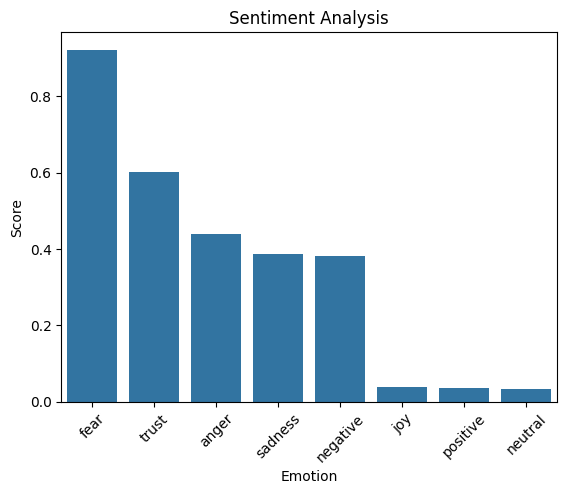

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x='Emotion', y='Score', data=df_sentiments)
plt.title('Sentiment Analysis')
plt.xticks(rotation=45)
plt.show()

Using device: cuda:0


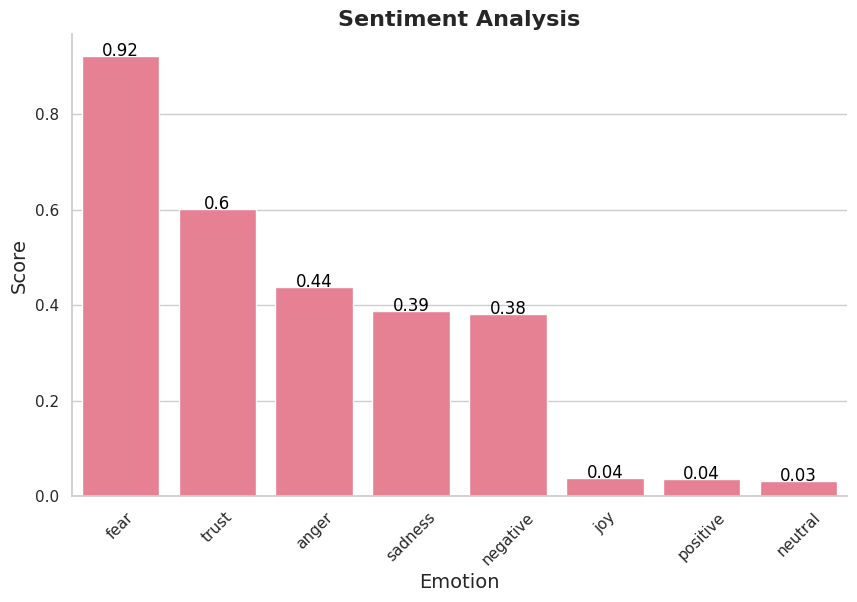

In [25]:

import matplotlib.pyplot as plt
import seaborn as sns



model_name = "facebook/bart-large-mnli"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")



def load_model(device):
  news_sentiment_analysis = pipeline(     # transformers pipeline
      "zero-shot-classification",   # give it the task
      model=model_name,               # giving it model that we want to use
      device=device)                # device it will use

  return news_sentiment_analysis


news_sentiment_analysis = load_model(device)


sentiment_list =  ["positive", "negative", "neutral", "joy", "sadness", "anger", "fear", "trust"]


def load_articles_dataset(article_str):
  # articles_df = pd.read_csv(dataset_path)

  analysis_output = news_sentiment_analysis(
  article_str,
  candidate_labels=sentiment_list,
  multi_label=True,
  )


  sentiments = {}
  for sentiment in analysis_output:
    for emotion, score in zip(analysis_output['labels'], analysis_output['scores']):
      if emotion not in sentiment_list:
        sentiments[emotion] = []
      sentiments[emotion] = score

  sentiments = {key: np.mean(np.array(val)) for key,val in sentiments.items()}

  # df_sentiments = pd.DataFrame(sentiments.items(), columns=['Emotion', 'Score'])

  df_sentiments = pd.DataFrame(sentiments.items(), columns=['Emotion', 'Score'])

  plt.figure(figsize=(10, 6))
  sns.set_theme(style="whitegrid")
  sns.set_palette("husl")

  bar_plot = sns.barplot(x='Emotion', y='Score', data=df_sentiments)

  plt.title('Sentiment Analysis', fontsize=16, fontweight='bold')
  plt.xlabel('Emotion', fontsize=14)
  plt.ylabel('Score', fontsize=14)

  for index, row in df_sentiments.iterrows():
      plt.text(index, row['Score'], round(row['Score'], 2), color='black', ha="center")

  plt.xticks(rotation=45)
  sns.despine()
  plt.show()

  return df_sentiments

dddff = load_articles_dataset(df2.iloc[0,0])


# POSITIVE NEGATIVE SUMMARY

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer
import torch

# Load BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

def classify_and_summarize(article):
    # Split article into sentences
    sentences = article.split('. ')

    positive_sentences = []
    negative_sentences = []

    # Classify each sentence using zero-shot classification
    for sentence in sentences:
        inputs = tokenizer.encode(sentence, return_tensors='pt')
        outputs = model.generate(inputs)
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Simple logic to classify based on prediction (this needs to be defined)
        if "positive" in prediction:
            positive_sentences.append(sentence)
        elif "negative" in prediction:
            negative_sentences.append(sentence)

    # Summarize positive and negative sentences
    def summarize(sentences):
        if not sentences:  # Check if there are any sentences to summarize
            return ""
        inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True, max_length=1024)
        summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=30)
        return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    positive_summary = summarize(positive_sentences)
    negative_summary = summarize(negative_sentences)

    return positive_summary, negative_summary

# Example usage
article_text = df2.iloc[0,0]
positive_summary, negative_summary = classify_and_summarize(article_text)
print("Positive Summary:", positive_summary)
print("Negative Summary:", negative_summary)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Positive Summary: 
Negative Summary: 


''

In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
summarizer(df2.iloc[0,0])

[{'summary_text': " NYPD says drones carrying explosives are the number one threat as they investigate ways to stop attacks . Police want to develop technology which will allow them to take control of drones . They are consulting with the military and working on a plan to counter weaponized drones . The NYPD hasn't received any intelligence indicating there is an imminent threat, but has become increasingly concerned over last year ."}]

Translation

In [ ]:
from transformers import pipeline

translator = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")
translator("Ce cours est produit par Hugging Face.")